In [1]:
"""
This script was developed to parallel process preformatted time series of input data needed for
the Kljun et. al 2d flux footprint prediction code and ultimately create daily-ETo-weighted
footprint georeferenced footprint rasters. 

Checks are performed on the input data to handle data quality issues. The weighting method 
uses normalized hourly proportions of ASCE ETo computed from NLDAS v2 data for the closest cell.
NLDAS data is automatically downloaded using OpenDAP given Earthdata login info. Only days with 
5 or more hours of data (only from hours between 6:00AM to 8:00 PM) must exist in a day. 
Checks are performed to ensure final weighting procedure was successful at different steps of 
the process. 

This script is not intended to be used by others but to document a workflow that was employed for
scientific purposes.
"""
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
import refet
import pyproj as proj
import xarray
import requests
import pynldas2 as nldas
import multiprocessing as mp
__author__='John Volk'

In [2]:
import sys
sys.path.append("../../scripts/") 
import calc_footprint_FFP_climatology as ffp
import footprint_funcs as ff

In [3]:
latitude = 41.1
longitude = -111.1
#ff.get_zones(latitude,longitude)
ff.find_epsg(latitude,longitude)

32612

In [4]:
# read metadata that has each sites' elevation used in ETr/ETo calcs
AMF_meta_path = Path('path/to/site_metadata')
AMF_meta = pd.read_csv(AMF_meta_path, index_col='SITE_ID')

FileNotFoundError: [Errno 2] No such file or directory: 'path\\to\\site_metadata'

In [ ]:
# specify path with input CSV files for each station with 
# input time series of needed data, e.g. zm, u_star, L,...
in_dir = Path('dir/with/input')
hourly_files = list(in_dir.glob('*.csv'))

In [ ]:
def read_compiled_input(path):
    """
    Check if required input data exists in file and is formatted appropriately.
    
    Input files should be hourly or finer temporal frequency, drops hours
    without required input data. 
    """
    ret = None
    need_vars = {'latitude','longitude','ET_corr','wind_dir','u_star','sigma_v','zm','hc','d','L'}
    #don't parse dates first check if required inputs exist to save processing time
    df=pd.read_csv(path, index_col='date', parse_dates=False)
    cols = df.columns
    check_1 = need_vars.issubset(cols)
    check_2 = len({'u_mean','z0'}.intersection(cols)) >= 1 # need one or the other
    # if either test failed then insufficient input data for footprint, abort
    if not check_1 or not check_2:
        return ret
    ret = df
    ret.index = pd.to_datetime(df.index)
    ret = ret.resample('H').mean()
    lat,lon = ret[['latitude','longitude']].values[0]
    keep_vars = need_vars.union({'u_mean','z0','IGBP_land_classification','secondary_veg_type'})
    drop_vars = list(set(cols).difference(keep_vars))
    ret.drop(drop_vars, 1, inplace=True)
    ret.dropna(subset=['wind_dir','u_star','sigma_v','d','zm','L','ET_corr'], how='any', inplace=True)
    return ret, lat, lon

In [21]:
import math
# Special zones for Svalbard and Norway
def getZones(longitude, latitude) :
    
    if (latitude >= 72.0 and latitude < 84.0 ) :
         if (longitude >= 0.0  and longitude <  9.0) :
              return 31              
    if (longitude >= 9.0  and longitude < 21.0):
          return 33
    if (longitude >= 21.0 and longitude < 33.0):
          return 35
    if (longitude >= 33.0 and longitude < 42.0) :
          return 37
    return (math.floor((longitude + 180) / 6) ) + 1 
    

def findEPSG(longitude, latitude) :
    
    zone = getZones(longitude, latitude)
    #zone = (math.floor((longitude + 180) / 6) ) + 1  # without special zones for Svalbard and Norway         
    epsg_code = 32600
    epsg_code += int(zone)
    if (latitude < 0): # South
        epsg_code += 100    
    return epsg_code
    
    
print(findEPSG(-111,41)    )

32612


In [1]:
#from pyproj import CRS
import utm
# use PROJ string, assuming a default WGS84
# crs = pyproj.CRS.from_string(f'+proj=utm +zone={zone_num} + south')
# or dictionary
wgs84_lat = 41
wgs84_lon = -112
#32612
utm.from_latlon(wgs84_lat,wgs84_lon)

(415897.86555468437, 4539238.589499824, 12, 'T')

In [9]:
import pathlib
import pynldas2 as nldas
%matplotlib inline

station="US-UTM"
nldas_out_dir = pathlib.Path('NLDAS_data')
if not nldas_out_dir.is_dir():
    nldas_out_dir.mkdir(parents=True, exist_ok=True)

out_dir = pathlib.Path('All_output')/'AMF'/f'{station}'

if not out_dir.is_dir():
    out_dir.mkdir(parents=True, exist_ok=True)

FileNotFoundError: [Errno 2] No such file or directory: '_static\\nldas_grid.png'

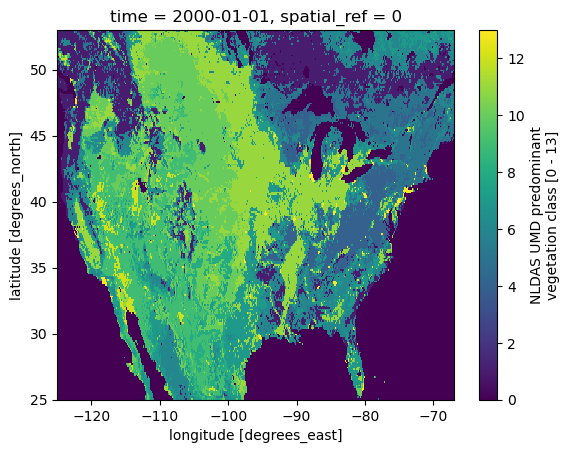

In [13]:
grid = nldas.get_grid_mask()
ax = grid.NLDAS_veg.plot()
ax.figure.savefig(pathlib.Path("_static", "nldas_grid.png"), facecolor="w", bbox_inches="tight")

https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods

In [14]:
date = pd.to_datetime('2020-07-01 10:00')
type(date) == str

False

In [ ]:
for date in df.index.date:
    # Subset dataframe to only values in day of year
    print(f'Date: {date}')
    temp_df = df[df.index.date == date]
    temp_df = temp_df.between_time(f'{start_hr:02}:00', f'{end_hr:02}:00')
    # check on n hours per day
    if len(temp_df) < 5:
        print(f'Less than 5 hours of data on {date}, skipping.')
        continue

    new_dat = None
    out_f = out_dir / f'{date}.tif'
    final_outf = out_dir / f'{date.year}-{date.month:02}-{date.day:02}_weighted.tif'
    
    if final_outf.is_file():
        print(f'final daily weighted footprint already wrote to: {final_outf}\nskipping.')
        continue  # do not overwrite date/site raster

    # make hourly band raster for the day
    for indx, hour in enumerate(hours_zero_indexed):
        band = indx + 1
        print(f'Hour: {hour}')
        try:
            temp_line = temp_df.loc[temp_df.index.hour == hour, :]
            if temp_line.empty:
                print(f'Missing all data for {date, hour} skipping')
                continue
            zm = temp_line.zm.values - temp_line.d.values
            z0 = temp_line.z0.values if 'z0' in temp_line.columns else None
            u_mean = temp_line.u_mean.values if 'u_mean' in temp_line.columns else None
            if u_mean is not None: z0 = None

            # Calculate footprint
            temp_ffp = ffp.ffp_climatology(
                domain=[-origin_d, origin_d, -origin_d, origin_d], dx=dx, dy=dx,
                zm=zm, h=h_s, rs=None, z0=z0, ol=temp_line['L'].values,
                sigmav=temp_line['sigma_v'].values,
                ustar=temp_line['u_star'].values, umean=u_mean,
                wind_dir=temp_line['wind_dir'].values,
                crop=0, fig=0, verbosity=0
            )
            f_2d = np.array(temp_ffp['fclim_2d'])
            x_2d = np.array(temp_ffp['x_2d']) + station_x
            y_2d = np.array(temp_ffp['y_2d']) + station_y
            f_2d = f_2d * dx ** 2

            # Calculate affine transform for given x_2d and y_2d
            affine_transform = ff.find_transform(x_2d, y_2d)

            # Create data file if not already created
            if new_dat is None:
                # print(f_2d.shape)
                new_dat = rasterio.open(
                    out_f, 'w', driver='GTiff', dtype=rasterio.float64,
                    count=n_hrs, height=f_2d.shape[0], width=f_2d.shape[1],
                    transform=affine_transform, crs=out_proj.srs,
                    nodata=0.00000000e+000
                )

        except Exception as e:
            print(f'Hour {hour} footprint failed, band {band} not written.')
            temp_ffp = None
            continue

        # Mask out points that are below a % threshold (defaults to 90%)
        f_2d = ff.mask_fp_cutoff(f_2d)
        # Write the new band
        new_dat.write(f_2d, indx + 1)
        # Update tags with metadata
        tag_dict = {'hour': f'{hour * 100:04}',
                    'wind_dir': temp_line['wind_dir'].values,
                    'total_footprint': np.nansum(f_2d)}

        new_dat.update_tags(indx + 1, **tag_dict)

    # Close dataset if it exists
    try:
        new_dat.close()
    except:
        print(f'ERROR: could not write footprint for site: {station}:\nto: {out_f}')
        continue  # skip to next day...

In [14]:
import pandas as pd
import refet
import numpy as np
import pathlib
latitude = 41.1
longitude = -112.1
#Other model parameters
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 30. #Model resolution [m]
origin_d = 300. #Model bounds distance from origin [m]
#modify if needed
start_hr = 6 # hours from 1 to 24
end_hr = 18

nldas_ts_outf = pathlib.Path("./nldas_ts_outf.csv")

date = pd.to_datetime('2020-07-01 10:00')

zm = 10.
elevation = 1025.

def ref_et_from_nldas(date='2020-07-01 10:00', latitude = 41.1, longitude = -112.1,zm = 10., 
                      elevation = 1025.):
    if type(date) == str:
        date = pd.to_datetime(date)
    
    df = nldas.get_bycoords([(longitude, latitude)], start_date=f'{date:%Y-%m-%d}', end_date=f'{date + pd.DateOffset(days=1):%Y-%m-%d}',source='netcdf')
    df['pair'] = df['psurf'].values / 1000
    df['ea'] = refet.calcs._actual_vapor_pressure(q=df['humidity'], pair=df['pair'])
    df['wind'] = np.sqrt(df['wind_u'] ** 2 + df['wind_v'] ** 2)
    df['temp_C'] = df['temp'].values - 273.15
    
    unit_dict = {'rs': 'w/m2'}
    
    # create refet object for calculating
    refet_obj = refet.Hourly(
        tmean=df['temp_C'], ea=df['ea'], rs=df['rsds'], uz=df['wind'],
        zw=zm, elev=elevation, lat=latitude, lon=longitude,
        doy=df.index.dayofyear, time=df.index.hour, method='asce', input_units=unit_dict) #HH must be int
    
    df['ETr'] = refet_obj.etr()
    df['ETo'] = refet_obj.eto()
    df.index.name = 'date'
    
    return df

# if first run save file with individual datetime (hour data) else open and overwrite hour
if not nldas_ts_outf.is_file():
    df.round(4).to_csv(nldas_ts_outf)
else:
    curr_df = pd.read_csv(nldas_ts_outf, index_col='date', parse_dates=True)
    curr_df.loc[df.index] = df.loc[df.index]
    curr_df.round(4).to_csv(nldas_ts_outf)    

In [17]:
latitude = 41.1
longitude = -112.1
station_coord = (latitude, longitude)
#get EPSG code from lat,long, convert to UTM
EPSG=32700-np.round((45+latitude)/90.0)*100+np.round((183+longitude)/6.0)
EPSG = int(EPSG)
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:{}'.format(EPSG))
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_19976\2743531886.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/

In [54]:
hour.hour

23

In [57]:
refet_obj.etr()

array([0.87784682])

In [ ]:
# get hourly time series of ETr and ETo, save
for hour in hours_zero_indexed:
    #NLDAS version 2, primary forcing set (a), DOY must be 3 digit zero padded, HH 2-digit between 00-23, MM and DD also 2 digit
    YYYY = date.year
    DOY = date.timetuple().tm_yday
    MM = date.month
    DD = date.day
    HH = hour
    # already ensured to exist above loop
    nldas_outf_path = nldas_out_dir / f'{YYYY}_{MM:02}_{DD:02}_{HH:02}.grb'
    # open grib and extract needed data at nearest gridcell, calc ETr/ETo anf append to time series
    ds = xarray.open_dataset(nldas_outf_path,engine='pynio').sel(lat_110=latitude, lon_110=longitude, method='nearest')
    # calculate hourly ea from specific humidity
    pair = ds.get('PRES_110_SFC').data / 1000 # nldas air pres in Pa convert to kPa
    sph = ds.get('SPF_H_110_HTGL').data # kg/kg
    ea = refet.calcs._actual_vapor_pressure(q=sph, pair=pair) # ea in kPa
    # calculate hourly wind
    wind_u = ds.get('U_GRD_110_HTGL').data
    wind_v = ds.get('V_GRD_110_HTGL').data
    wind = np.sqrt(wind_u ** 2 + wind_v ** 2)
    # get temp convert to C
    temp = ds.get('TMP_110_HTGL').data - 273.15
    # get rs
    rs = ds.get('DSWRF_110_SFC').data
    unit_dict = {'rs': 'w/m2'}
    # create refet object for calculating

    refet_obj = refet.Hourly(
        tmean=temp, ea=ea, rs=rs, uz=wind,
        zw=zm, elev=elevation, lat=latitude, lon=longitude,
        doy=DOY, time=HH, method='asce', input_units=unit_dict) #HH must be int

    # this one is saved under the site_ID subdir
    nldas_ts_outf = out_dir/ f'nldas_ETr.csv'
    # save/append time series of point data
    dt = pd.to_datetime(YYYY,MM,DD,HH)
    ETr_df = pd.DataFrame(columns=['ETr','ETo','ea','sph','wind','pair','temp','rs'])
    ETr_df.loc[dt, 'ETr'] = refet_obj.etr()[0]
    ETr_df.loc[dt, 'ETo'] = refet_obj.eto()[0]
    ETr_df.loc[dt, 'ea'] = ea[0]
    ETr_df.loc[dt, 'sph'] = sph
    ETr_df.loc[dt, 'wind'] = wind
    ETr_df.loc[dt, 'pair'] = pair
    ETr_df.loc[dt, 'temp'] = temp
    ETr_df.loc[dt, 'rs'] = rs
    ETr_df.index.name = 'date'

    # if first run save file with individual datetime (hour data) else open and overwrite hour
    if not nldas_ts_outf.is_file():
        ETr_df.round(4).to_csv(nldas_ts_outf)
    else:
        curr_df = pd.read_csv(nldas_ts_outf, index_col='date', parse_dates=True)
        curr_df.loc[dt] = ETr_df.loc[dt]
        curr_df.round(4).to_csv(nldas_ts_outf)    

# Now have hourly input data including station coords

In [ ]:
# constant declarations
EPSG_BASE = 32700
EPSG_CONV_FACTOR1 = 90.0
EPSG_CONV_FACTOR2 = 6.0
EPSG_OUT_INIT = 'EPSG:{}'
COORD_ADJUSTMENT = 15

def sanitize_coordinate(coordinate):
    remainder = coordinate % COORD_ADJUSTMENT
    if remainder > COORD_ADJUSTMENT / 2:
        coordinate += (COORD_ADJUSTMENT - remainder)
        if (coordinate / COORD_ADJUSTMENT) % 2 == 0:
            coordinate -= COORD_ADJUSTMENT
    else:
        coordinate -= remainder
        if (coordinate / COORD_ADJUSTMENT) % 2 == 0:
            coordinate += COORD_ADJUSTMENT
    return coordinate

def runner(path, ed_user, ed_pass):
    """
    Given path to time series of site hourly (or finer) input data,
    compute daily ETo weighted footprint rasters. 
    Requires NASA Earthdata username and password to download NLDAS-v2
    primary forcing at point locations for estimated ASCE short ref. ET.
    """
    df, latitude, longitude = read_compiled_input(path)
    station = path.stem
    elevation = AMF_meta.loc[station, 'station_elevation']
    station_coord = (longitude, latitude)
    EPSG = EPSG_BASE - round((45 + latitude) / EPSG_CONV_FACTOR1) * 100 + round((183 + longitude) / EPSG_CONV_FACTOR2)
    EPSG = int(EPSG)
    in_proj = proj.Proj(init='EPSG:4326')
    out_proj = proj.Proj(init=EPSG_OUT_INIT.format(EPSG))
    (station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)
    station_x = sanitize_coordinate(station_x)
    station_y = sanitize_coordinate(station_y)
    print('adjusted coordinates:',station_x,station_y)
    # Other code remains the same...
    

In [ ]:
def runner(path, ed_user, ed_pass):
    """
    Given path to time series of site hourly (or finer) input data,
    compute daily ETo weighted footprint rasters. 
    
    Requires NASA Earthdata username and password to download NLDAS-v2
    primary forcing at point locations for estimated ASCE short ref. ET.
    """
        
    df, latitude, longitude = read_compiled_input(path)
    station = path.stem
    elevation = AMF_meta.loc[station, 'station_elevation']

    station_coord = (longitude, latitude)
    # get EPSG code from lat,long, convert to UTM
    EPSG=32700-np.round((45+latitude)/90.0)*100+np.round((183+longitude)/6.0)
    EPSG = int(EPSG)
    in_proj = proj.Proj(init='EPSG:4326')
    out_proj = proj.Proj(init='EPSG:{}'.format(EPSG))
    (station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)
    print('original coordinates:',station_x,station_y)
    # move coord to snap centroid to 30m grid, minimal distortion
    rx = station_x % 15
    if rx > 7.5:
        station_x += (15-rx)
        # final coords should be odd factors of 15
        if (station_x / 15) % 2 == 0:
            station_x -= 15
    else:    
        station_x -= rx
        if (station_x / 15) % 2 == 0:
            station_x += 15
            
    ry = station_y % 15
    if ry > 7.5:
        print('ry > 7.5')
        station_y += (15-ry )
        if (station_y / 15) % 2 == 0:
            station_y -= 15
    else:
        print('ry <= 7.5')
        station_y -= ry
        if (station_y / 15) % 2 == 0:
            station_y += 15
    print('adjusted coordinates:',station_x,station_y)

    #Other model parameters
    h_s = 2000. #Height of atmos. boundary layer [m] - assumed
    dx = 30. #Model resolution [m]
    origin_d = 300. #Model bounds distance from origin [m]
    #modify if needed
    start_hr = 6 # hours from 1 to 24
    end_hr = 18
    hours_zero_indexed = np.arange(start_hr-1,end_hr)
    hours_one_indexed = np.arange(start_hr,end_hr+1)

    n_hrs = len(hours_zero_indexed) 

    nldas_out_dir = Path('NLDAS_data')
    if not nldas_out_dir.is_dir():
        nldas_out_dir.mkdir(parents=True, exist_ok=True)

    out_dir = Path('All_output')/'AMF'/f'{station}'

    if not out_dir.is_dir():
        out_dir.mkdir(parents=True, exist_ok=True)

    #Loop through each day in the dataframe
    for date in df.index.date:
        #Subset dataframe to only values in day of year
        print(f'Date: {date}')
        temp_df = df[df.index.date == date]
        temp_df=temp_df.between_time(f'{start_hr:02}:00', f'{end_hr:02}:00')
        # check on n hours per day
        if len(temp_df) < 5:
            print(f'Less than 5 hours of data on {date}, skipping.')
            continue
            
        new_dat = None

        out_f = out_dir/ f'{date}.tif'

        final_outf = out_dir/f'{date.year}-{date.month:02}-{date.day:02}_weighted.tif'
        if final_outf.is_file():
            print(f'final daily weighted footprint already wrote to: {final_outf}\nskipping.')
            continue # do not overwrite date/site raster 

        # make hourly band raster for the day
        for indx, hour in enumerate(hours_zero_indexed):

            band = indx + 1
            print(f'Hour: {hour}')

            try:
                temp_line = temp_df.loc[temp_df.index.hour == hour,:]
                if temp_line.empty: 
                    print(f'Missing all data for {date,hour} skipping')
                    continue
                zm = temp_line.zm.values - temp_line.d.values
                z0 = temp_line.z0.values if 'z0' in temp_line.columns else None
                u_mean = temp_line.u_mean.values if 'u_mean' in temp_line.columns else None
                if u_mean is not None: z0 = None

                #Calculate footprint
                temp_ffp = ffp.ffp_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                        zm=zm, h=h_s, rs=None, z0=z0, 
                                        ol=temp_line['L'].values,sigmav=temp_line['sigma_v'].values,
                                        ustar=temp_line['u_star'].values, umean=u_mean,
                                        wind_dir=temp_line['wind_dir'].values,
                                        crop=0,fig=0,verbosity=0)
                f_2d = np.array(temp_ffp['fclim_2d'])
                x_2d = np.array(temp_ffp['x_2d']) + station_x
                y_2d = np.array(temp_ffp['y_2d']) + station_y
                f_2d = f_2d*dx**2

                #Calculate affine transform for given x_2d and y_2d
                affine_transform = ff.find_transform(x_2d,y_2d)

                #Create data file if not already created
                if new_dat is None:
                    #print(f_2d.shape)
                    new_dat = rasterio.open(
                        out_f,'w',driver='GTiff',dtype=rasterio.float64,
                        count=n_hrs,height=f_2d.shape[0],width=f_2d.shape[1],
                        transform=affine_transform, crs=out_proj.srs,
                        nodata=0.00000000e+000
                    )

            except Exception as e:
                print(f'Hour {hour} footprint failed, band {band} not written.')

                temp_ffp = None

                continue

            #Mask out points that are below a % threshold (defaults to 90%)
            f_2d = ff.mask_fp_cutoff(f_2d)

            #Write the new band
            new_dat.write(f_2d, indx+1)

            #Update tags with metadata
            tag_dict = {'hour':f'{hour*100:04}',
                        'wind_dir':temp_line['wind_dir'].values,
                        'total_footprint':np.nansum(f_2d)}

            new_dat.update_tags(indx+1,**tag_dict)

        #Close dataset if it exists
        try:
            new_dat.close()
        except:
            print(f'ERROR: could not write footprint for site: {station}:\nto: {out_f}')
            continue # skip to next day...

        # for NLDAS data from pymetric
        for hour in hours_zero_indexed:
            #NLDAS version 2, primary forcing set (a), DOY must be 3 digit zero padded, HH 2-digit between 00-23, MM and DD also 2 digit
            YYYY = date.year
            DOY = date.timetuple().tm_yday
            MM = date.month
            DD = date.day
            HH = hour

            nldas_outf_path = nldas_out_dir / f'{YYYY}_{MM:02}_{DD:02}_{HH:02}.grb'
            if nldas_outf_path.is_file():
                print(f'{nldas_outf_path} already exists, not overwriting.')
                pass
                # do not overwrite!
            else:
                data_url = f'https://hydro1.gesdisc.eosdis.nasa.gov/data/NLDAS/NLDAS_FORA0125_H.002/{YYYY}/{DOY:03}/NLDAS_FORA0125_H.A{YYYY}{MM:02}{DD:02}.{HH:02}00.002.grb'
                session = requests.Session()
                r1 = session.request('get', data_url)
                r = session.get(r1.url, stream=True, auth=(ed_user, ed_pass))

                # write grib file temporarily
                with open(nldas_outf_path, 'wb') as outf:
                    for chunk in r.iter_content(chunk_size=1024 * 1024):
                        if chunk:  # filter out keep-alive new chunks
                            outf.write(chunk)


        # get hourly time series of ETr and ETo, save
        for hour in hours_zero_indexed:
            #NLDAS version 2, primary forcing set (a), DOY must be 3 digit zero padded, HH 2-digit between 00-23, MM and DD also 2 digit
            YYYY = date.year
            DOY = date.timetuple().tm_yday
            MM = date.month
            DD = date.day
            HH = hour
            # already ensured to exist above loop
            nldas_outf_path = nldas_out_dir / f'{YYYY}_{MM:02}_{DD:02}_{HH:02}.grb'
            # open grib and extract needed data at nearest gridcell, calc ETr/ETo anf append to time series
            ds = xarray.open_dataset(nldas_outf_path,engine='pynio').sel(lat_110=latitude, lon_110=longitude, method='nearest')
            # calculate hourly ea from specific humidity
            pair = ds.get('PRES_110_SFC').data / 1000 # nldas air pres in Pa convert to kPa
            sph = ds.get('SPF_H_110_HTGL').data # kg/kg
            ea = refet.calcs._actual_vapor_pressure(q=sph, pair=pair) # ea in kPa
            # calculate hourly wind
            wind_u = ds.get('U_GRD_110_HTGL').data
            wind_v = ds.get('V_GRD_110_HTGL').data
            wind = np.sqrt(wind_u ** 2 + wind_v ** 2)
            # get temp convert to C
            temp = ds.get('TMP_110_HTGL').data - 273.15
            # get rs
            rs = ds.get('DSWRF_110_SFC').data
            unit_dict = {'rs': 'w/m2'}
            # create refet object for calculating

            refet_obj = refet.Hourly(
                tmean=temp, ea=ea, rs=rs, uz=wind,
                zw=zm, elev=elevation, lat=latitude, lon=longitude,
                doy=DOY, time=HH, method='asce', input_units=unit_dict) #HH must be int

            # this one is saved under the site_ID subdir
            nldas_ts_outf = out_dir/ f'nldas_ETr.csv'
            # save/append time series of point data
            dt = pd.datetime(YYYY,MM,DD,HH)
            ETr_df = pd.DataFrame(columns=['ETr','ETo','ea','sph','wind','pair','temp','rs'])
            ETr_df.loc[dt, 'ETr'] = refet_obj.etr()[0]
            ETr_df.loc[dt, 'ETo'] = refet_obj.eto()[0]
            ETr_df.loc[dt, 'ea'] = ea[0]
            ETr_df.loc[dt, 'sph'] = sph
            ETr_df.loc[dt, 'wind'] = wind
            ETr_df.loc[dt, 'pair'] = pair
            ETr_df.loc[dt, 'temp'] = temp
            ETr_df.loc[dt, 'rs'] = rs
            ETr_df.index.name = 'date'

            # if first run save file with individual datetime (hour data) else open and overwrite hour
            if not nldas_ts_outf.is_file():
                ETr_df.round(4).to_csv(nldas_ts_outf)
            else:
                curr_df = pd.read_csv(nldas_ts_outf, index_col='date', parse_dates=True)
                curr_df.loc[dt] = ETr_df.loc[dt]
                curr_df.round(4).to_csv(nldas_ts_outf)    

        # do hourly weighting - do not necessarily need to do this all in the same loop
        src = rasterio.open(out_f)
        # hourly fetch scalar sums
        global_sum = np.zeros(shape=(n_hrs))
        for hour in range(1,n_hrs+1):
            arr = src.read(hour)
            global_sum[hour-1] = arr.sum()
        # normalized fetch rasters
        normed_fetch_rasters = [] 
        for hour in range(1,n_hrs+1):
            arr = src.read(hour)
            tmp = arr / global_sum[hour-1]
            if np.isnan(tmp).all():
                tmp = np.zeros_like(tmp)
            normed_fetch_rasters.append(tmp)
        # get NLDAS ts calc fraction of daily ETo
        nldas_df = pd.read_csv(nldas_ts_outf, index_col='date', parse_dates=True).sort_index()
        ETo = nldas_df.loc[nldas_df.index.date == date, 'ETo']
        min_max_normed_ETo = (ETo-min(ETo))/(max(ETo)-min(ETo)) # deal with negative ETo value proportions
        # take out hours where footprint does not exist
        i = 0
        for e, s in zip(min_max_normed_ETo.values, global_sum):
            if s == 0:
                min_max_normed_ETo.iloc[i] = 0
            i+=1
        # after removing hours now calculate hourly proportions
        nldas_df.loc[nldas_df.index.date == date, 'ETo_hr_props'] = min_max_normed_ETo / min_max_normed_ETo.sum()
        # weight normed hourly fetch rasters by hourly ETo proportions
        for i,hour in enumerate(hours_zero_indexed): # everything here is hours 0-23
            normed_fetch_rasters[i] =\
                normed_fetch_rasters[i]*nldas_df.loc[
                    (nldas_df.index.date == date) & (nldas_df.index.hour == hour), 'ETo_hr_props'
            ].values[0]
        # save hourly proportions to time series file
        nldas_df.round(4).to_csv(nldas_ts_outf)

        # Last calculation, sum the weighted hourly rasters to a single daily fetch raster
        final_footprint = sum(normed_fetch_rasters)
        assert np.isclose(final_footprint.sum(), 1), f'check 1 failed! {final_footprint.sum()}\n{temp_line}'
        # next check
        for hour, raster in enumerate(normed_fetch_rasters):
            assert np.isclose(
                nldas_df.loc[
                    (nldas_df.index.date == date) & (nldas_df.index.hour == hour+start_hr-1), 'ETo_hr_props'
                ].values[0], raster.sum()
            ), f'check 2 failed for hour {hour+start_hr-1}!!!'

        # finally, write daily corrected raster with UTM zone reference 
        corr_raster_path = final_outf
        out_raster = rasterio.open(
            corr_raster_path,'w',driver='GTiff',dtype=rasterio.float64,
            count=1,height=final_footprint.shape[0],width=final_footprint.shape[1],
            transform=src.transform, crs=out_proj.srs, nodata=0.00000000e+000
        )
        out_raster.write(final_footprint,1)
        out_raster.close()
        


In [ ]:
pool = mp.Pool(processes=8)
pool.map(runner,hourly_files)